In [124]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modelado y Forecasting
# ==============================================================================
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión skforecast: 0.12.1
Versión scikit-learn: 1.4.2
Versión pandas: 2.2.2
Versión numpy: 1.26.4


In [141]:
Df_O_salidas = pd.read_excel('./Data resumida.xlsx')
Df_O_salidas['FECHA_RIGE']= pd.to_datetime(Df_O_salidas['FECHA_RIGE'],format='%d-%m-%Y')
fecha_limite = pd.to_datetime('30-06-2024', format='%d-%m-%Y')
Df_O_salidas = Df_O_salidas[Df_O_salidas['FECHA_RIGE']<=fecha_limite]
Df_O_salidas['Year_month'] = Df_O_salidas['FECHA_RIGE']+ pd.offsets.MonthEnd(0)
Df_O_salidas = Df_O_salidas.sort_values('Year_month')
Df_agrupado = Df_O_salidas.groupby(by=['Year_month', 'DEPTO_ACTUAL'])['Recuento_de_salida'].sum().reset_index()
valores_unicos = pd.unique(Df_O_salidas['DEPTO_ACTUAL'])
decer = Df_agrupado
  
df_unificado = []

for rest in valores_unicos :
    dfderecurrencia = Df_agrupado[Df_agrupado['DEPTO_ACTUAL'] == rest].copy()
    dfderecurrencia.set_index('Year_month', inplace=True)
    dfderecurrencia = dfderecurrencia.asfreq('M')
    dfderecurrencia.sort_index()
    # Añadir el departamento al DataFrame resultante
    dfderecurrencia['DEPTO_ACTUAL'] = rest
    dfderecurrencia['Recuento_de_salida'] = dfderecurrencia['Recuento_de_salida'].fillna(0)
    # Hacer un 'push' (append) de dfderecurrencia a df_unificado
    df_unificado.append(dfderecurrencia)
# Resetear el índice de df_unificado si es necesario

df_unificadopd = pd.concat(df_unificado, ignore_index=False)
#df_unificadopd.to_excel('./resultado.xlsx')
#Restaurante_unicos = pd.unique(Df_agrupado['DEPTO_ACTUAL'])
print(df_unificadopd)
#Df_agrupado['Year_month'] = pd.to_datetime(Df_agrupado['Year_month'])
#Df_agrupado = Df_agrupado.set_index(['Year_month','DEPTO_ACTUAL'])


# Mostrar los primeros resultados
#Df_agrupado.head()

c:\Users\gabriel.castro\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
C:\Users\gabriel.castro\AppData\Local\Temp\ipykernel_10884\2407837621.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dfderecurrencia = dfderecurrencia.asfreq('M')


           DEPTO_ACTUAL  Recuento_de_salida
Year_month                                 
2019-01-31         DD43                 1.0
2019-02-28         DD43                 0.0
2019-03-31         DD43                 1.0
2019-04-30         DD43                 0.0
2019-05-31         DD43                 1.0
...                 ...                 ...
2024-03-31         DD52                 1.0
2024-05-31         LC49                 3.0
2024-05-31         PP33                 2.0
2024-05-31         D120                 1.0
2024-06-30         CK64                 2.0

[12554 rows x 2 columns]


            Recuento_de_salida
Year_month                    
2019-01-31               121.0
2019-02-28               117.0
2019-03-31                67.0
2019-04-30                63.0
2019-05-31                69.0
...                        ...
2024-02-29               169.0
2024-03-31               126.0
2024-04-30               188.0
2024-05-31               174.0
2024-06-30               189.0

[66 rows x 1 columns]


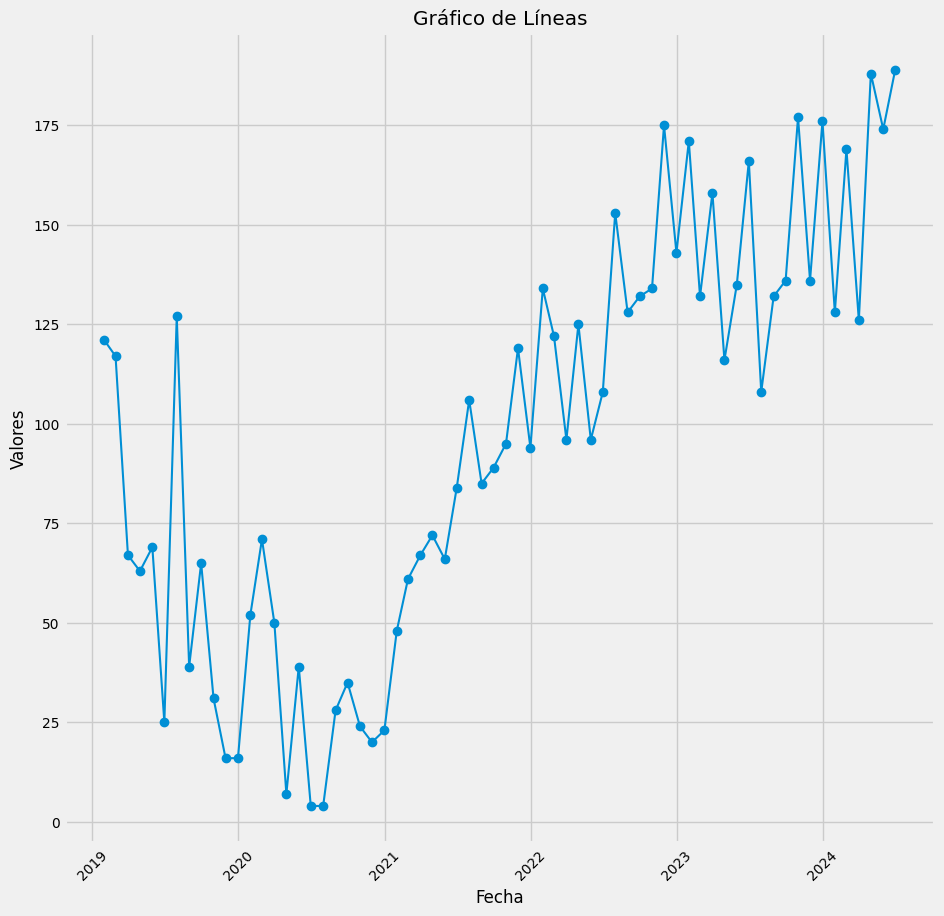

In [142]:
df_unificadopd2 = df_unificadopd.groupby(by=df_unificadopd.index)['Recuento_de_salida'].sum().reset_index()
df_unificadopd2.set_index('Year_month', inplace=True)
df_unificadopd2.index = pd.to_datetime(df_unificadopd2.index)
print(df_unificadopd2)

plt.figure(figsize=(10,10))
plt.plot(df_unificadopd2.index,df_unificadopd2['Recuento_de_salida'],scalex='M',marker='o')
# Formato del eje X
plt.xlabel('Fecha')  # Etiqueta del eje X
plt.ylabel('Valores')  # Etiqueta del eje Y
plt.title('Gráfico de Líneas')
plt.xticks(rotation=45) 
plt.show()

La Gafica linea muestra que hay una tendencia a la alza con una etacionalidad aditiva sin contar el periodo 2020 que esa anormalidad se abduce que es por la pandemia

Train dates : 2019-01-31 00:00:00 --- 2022-12-31 00:00:00  (n=48)
Test dates  : 2023-01-31 00:00:00 --- 2024-06-30 00:00:00  (n=18)


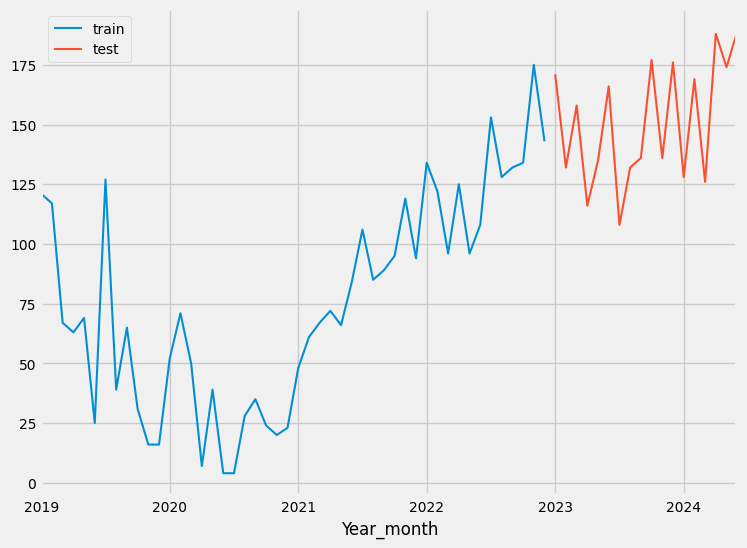

In [143]:
steps = 18
data_train = df_unificadopd2[:-steps]
data_test  = df_unificadopd2[-steps:]

print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)
fig, ax = plt.subplots(figsize=(8, 6))
data_train['Recuento_de_salida'].plot(ax=ax, label='train')
data_test['Recuento_de_salida'].plot(ax=ax, label='test')
ax.legend()

In [144]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 6
             )
forecaster.fit(y=data_train['Recuento_de_salida'])
forecaster

c:\Users\gabriel.castro\AppData\Local\Programs\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1058: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\Users\gabriel.castro\AppData\Local\Programs\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1058: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 47] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-08-23 16:31:30 
Last fit date: 2024-08-23 16:31:30 
Skforecast version: 0.12.1 
Python version: 3.12.3 
Forecaster id: None 

6     135.49
7     131.67
8     150.92
9     144.86
10    135.70
11    135.39
12    151.74
13    151.81
14    135.61
15    135.39
16    151.74
17    151.81
18    135.61
19    135.39
20    151.74
21    151.81
22    135.61
23    135.39
Name: Predicción, dtype: float64
            Predicción
2023-01-31      135.49
2023-02-28      131.67
2023-03-31      150.92
2023-04-30      144.86
2023-05-31      135.70
2023-06-30      135.39
2023-07-31      151.74
2023-08-31      151.81
2023-09-30      135.61
2023-10-31      135.39
2023-11-30      151.74
2023-12-31      151.81
2024-01-31      135.61
2024-02-29      135.39
2024-03-31      151.74
2024-04-30      151.81
2024-05-31      135.61
2024-06-30      135.39


c:\Users\gabriel.castro\AppData\Local\Programs\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1120: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\gabriel.castro\AppData\Local\Temp\ipykernel_10884\4175847468.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pred_index = pd.date_range(


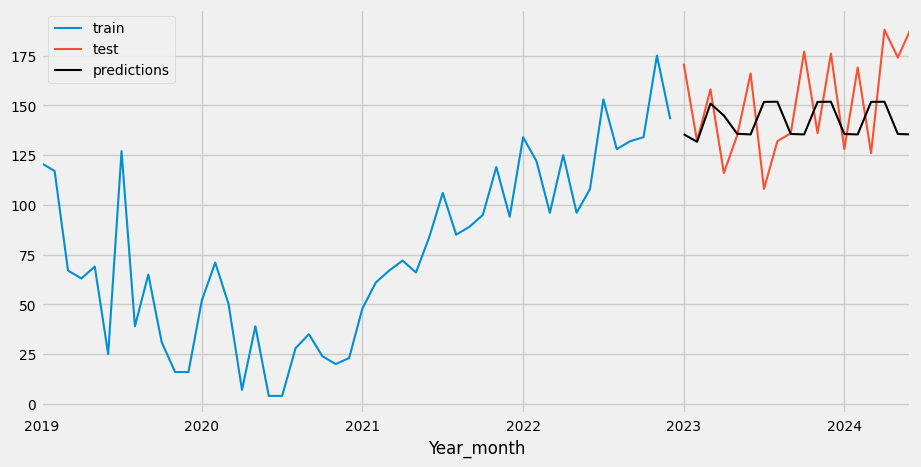

2022-12-31 00:00:00 2023-01-31 00:00:00


In [145]:
# Supongamos que `data_train` y `data_test` ya están definidos, y contienen un índice de fechas.

# Generar las predicciones
steps = 18
predictions = pd.Series(
    data=forecaster.predict(steps=steps),
    name='Predicción'
)

print(predictions)
# Crear un índice de fechas para las predicciones
pred_index = pd.date_range(
    start=data_train.index[-1] + pd.Timedelta(days=1), 
    periods=steps, 
    freq='M'  # Ajusta la frecuencia según tu serie temporal
)

# Alinear las predicciones con el índice
predictions.index = pred_index

# Crear un DataFrame con las predicciones (ya alineado)
predictions_df = pd.DataFrame(predictions)


print(predictions_df)
# Graficar los datos
fig, ax = plt.subplots(figsize=(10, 5))
data_train['Recuento_de_salida'].plot(ax=ax, label='train')
data_test['Recuento_de_salida'].plot(ax=ax, label='test')
predictions_df['Predicción'].plot(ax=ax, label='predictions', color='black')
ax.legend()
plt.show()

print(data_train.index.max(),predictions_df.index.min())


In [146]:
error_mse = mean_squared_error(
                y_true = data_test['Recuento_de_salida'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")


steps2= 18

forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 12 # This value will be replaced in the grid search
             )

lags_grid = [6, 12]
# Definir el espacio de búsqueda para los hiperparámetros
param_grid = {
    'n_estimators': [100, 250],  # Número de árboles en el bosque
    'max_depth': [3, 8],          # Profundidad máxima de los árboles
}




# Realizar la búsqueda de hiperparámetros
results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data_train['Recuento_de_salida'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = steps,
                   metric             = 'mean_squared_error',
                   initial_train_size = int(len(data_train)*0.5),
                   fixed_train_size   = False,
                   refit              = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )



Test error (MSE): 858.8478222222225
Number of models compared: 8.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

c:\Users\gabriel.castro\AppData\Local\Programs\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1058: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\Users\gabriel.castro\AppData\Local\Programs\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1058: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\Users\gabriel.castro\AppData\Local\Programs\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1120: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\Users\gabriel.castro\AppData\Local\Programs\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1120: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


KeyError: "None of [Index([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,\n        6,  7,  8,  9, 10, 11],\n      dtype='int64')] are in the [index]"